In [1]:
import os
import numpy as np
import numpy.random as npr
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
#plt.switch_backend('agg')

from scipy.integrate import odeint

keras = tf.keras
tf.compat.v1.enable_eager_execution()

#from neural_ode import NeuralODE

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [3]:
# Definition of the Lotka-Volterra model, with VP = f(x(t), t; theta)
def VP(z, t, alpha, beta, gamma, sigma):
    x, y = z
    dzdt = [alpha * x - beta * x * y, - gamma * y + sigma * x*y]
    return dzdt

# Function to plot the trajectories in the 2D state space
def plot_traj(trajectories, width = 1.):
    x = trajectories[:,0]
    y = trajectories[:,1]
    plt.plot(x, y, linewidth = width)

In [4]:
# Data of the problem
data_size = 16001  # Size of the dataset (fictitious and created by adding noise to the real
                   #  data found through the integration of the system)
batch_time = 320  #
niters = 1000  # Number of Hamiltonian MC iterations
batch_size = 1000

# Parameters of the true model
alpha = 1.
beta = 0.1
gamma = 1.5
sigma = 0.75

In [5]:
t_grid = np.linspace(0, 25, data_size)
z0 = [5., 5.]
true_yy = odeint(VP, z0, t_grid, args=(alpha, beta, gamma, sigma))

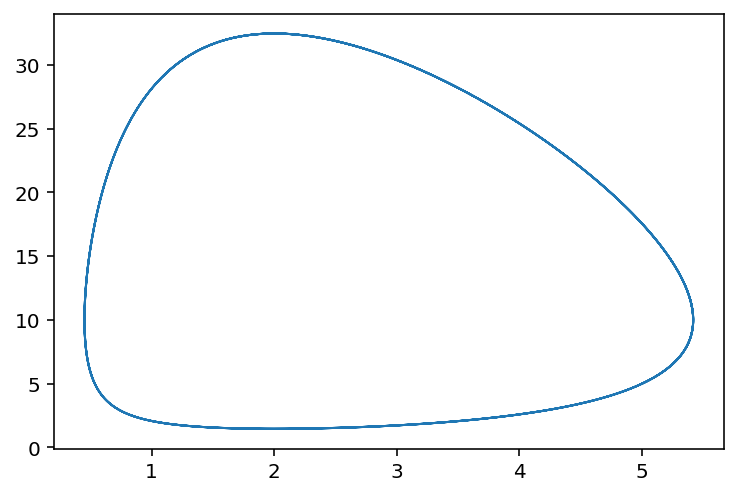

In [6]:
plot_traj(true_yy)

In [7]:
true_y = true_yy.copy()

sigma_x = np.std(true_yy[:, 0:1])  # Standard deviation of data for x = preys
sigma_y = np.std(true_yy[:, 1:2])  # Standard deviation of data for y = predators

noise_level = 0.03  # Adding some nois with this noise level
sigma_normal = max(sigma_x, sigma_y)  # Considering the highest between the 2

true_y[:, 0:1] = true_y[:, 0:1]/sigma_x + noise_level * np.random.randn(true_y[:, 0:1].shape[0], true_y[:, 0:1].shape[1])
true_y[:, 1:2] = true_y[:, 1:2]/sigma_y + noise_level * np.random.randn(true_y[:, 1:2].shape[0], true_y[:, 1:2].shape[1])
# The 2 lines above normalize the data and then add a noise being extract from a gaussian
#  random variable with 0 mean and (noise_level)^2 variance.

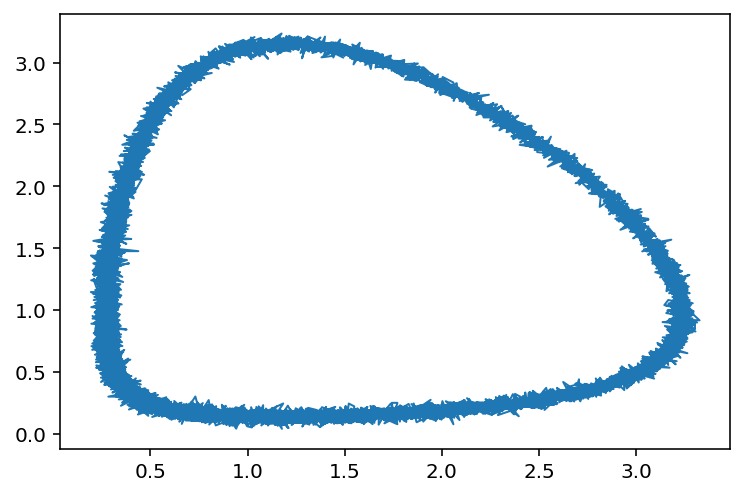

In [8]:
plot_traj(true_y)

In [10]:
def get_batch():
    """Returns initial point and last point over sampled frament of trajectory"""
    starts = np.random.choice(np.arange(data_size - batch_time - 1, dtype=np.int64), batch_size, replace=False)
    # This randomly chooses from {0, 1, ... , data_size - batch_time - 1}, batch_size different elements
    batch_y0 = true_y[starts] 
    batch_yN = true_y[starts + batch_time]
    # The function returns a tensor composed by some y0 and the respective yN,
    #  being y0 + DeltaT.
    return tf.cast(batch_y0, dtype=tf.float32), tf.cast(batch_yN, dtype=tf.float32)

In [12]:
num_param = 4  # Number of parameters
para_num = num_param

t0 = t_grid[:batch_time][0]  # t0 = first element of t_grid
t1 = t_grid[:batch_time][-1]  # t1 = the element of t_grid at batch_time
t_in = np.linspace(t0, t1, 20)  # The time grid between t0 and t1

batch_y0, batch_yN = get_batch()  # Returns the first and the last y observed for each batch

In [13]:
from neural_ode import NeuralODE

In [15]:
#########################################
#         precondition start            #
#########################################
niters_pre = 1000  # Number of iterations of the preconditioner

class ODEModel_pre(tf.keras.Model):
    def __init__(self):
        super(ODEModel_pre, self).__init__()
        self.Weights = tf.Variable(tf.random.normal([num_param, 1], dtype=tf.float32)*0.01, dtype=tf.float32)
    # Initializer: assign normally distributed random weights which are very close to zero

    def call(self, inputs, **kwargs):
        t, y = inputs
        h = y
        h1 = h[:, 0:1]  # preys
        h2 = h[:, 1:2]  # predators

        p1 = self.Weights[0]
        p2 = self.Weights[1]
        p3 = self.Weights[2]
        p4 = self.Weights[3]

        h_out1 = p1 * h1 + sigma_y * p2 * h2*h1  # Why sigma_y?? Think it's due to normalization, but boh
        h_out2 = p3 * h2 + sigma_x * p4 * h2*h1  # Why sigma_x??
        h_out = tf.concat([h_out1, h_out2], 1)
        # This function is computing the f(x(t), t; p) at [x,t] in 'inputs' and with p
        #  the actual weights of the model
        return h_out
    
model_pre = ODEModel_pre()
neural_ode_pre = NeuralODE(model_pre, t_in)
optimizer = tf.compat.v1.train.AdamOptimizer(3e-2)

In [16]:
@tf.function
def compute_gradients_and_update_pre(batch_y0, batch_yN):
    """Takes start positions (x0, y0) and final positions (xN, yN)"""
    pred_y = neural_ode_pre.forward(batch_y0)  # Predict y using Runge-Kutta 4 for each y0 in batch_y0
    with tf.GradientTape() as g_pre:
        g_pre.watch(pred_y)
        loss = tf.reduce_mean(input_tensor=(pred_y - batch_yN)**2) + tf.reduce_sum(input_tensor=tf.abs(model_pre.trainable_weights[0]))
        # This step is computing the loss function
    dLoss = g_pre.gradient(loss, pred_y)  # Here we compute the gradient of the loss function
    h_start, dfdh0, dWeights = neural_ode_pre.backward(pred_y, dLoss)  # Here we compute the dWeights
    optimizer.apply_gradients(zip(dWeights, model_pre.weights))  # Here we update the weights
    return loss, dWeights

parameters_pre = np.zeros((para_num, 1))

from tqdm import tqdm

for step in tqdm(range(niters_pre)):
    loss, dWeights = compute_gradients_and_update_pre(batch_y0, batch_yN)
    parameters_pre = model_pre.trainable_weights[0].numpy()

print(parameters_pre)

#########################################
#          precondition end             #
#########################################

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:39<00:00, 25.14it/s]

[[ 0.99800324]
 [-0.10007777]
 [-1.5066575 ]
 [ 0.753589  ]]


In [17]:
initial_weight = parameters_pre  # We initialize the weights with the parameters found in preconditioning
print(initial_weight.shape, "here")


class ODEModel(tf.keras.Model):
    def __init__(self):
        super(ODEModel, self).__init__()
        self.Weights = tf.Variable(tf.random.normal([num_param, 1], dtype=tf.float32)*0.01, dtype=tf.float32)
        # Initializer, initializes the weight to normal random variables with sd = 0.01

    def call(self, inputs, **kwargs):
        t, y = inputs
        h = y
        h1 = h[:, 0:1]
        h2 = h[:, 1:2]

        p1 = self.Weights[0]
        p2 = self.Weights[1]
        p3 = self.Weights[2]  
        p4 = self.Weights[3] 

        h_out1 = p1 * h1 + sigma_y * p2 * h2*h1  # ?? As before, why sigma_y?
        h_out2 = p3 * h2 + sigma_x * p4 * h2*h1  # ?? As before, why sigma_x?
        h_out = tf.concat([h_out1, h_out2], 1)
        return h_out
    
model = ODEModel()
neural_ode = NeuralODE(model, t=t_in)  # We assign to NeuralODE the just created model and the time grid  between t0 and t1

temp_model = ODEModel()
neural_ode_temp = NeuralODE(temp_model, t=t_in)

@tf.function
def compute_gradients_and_update(batch_y0, batch_yN): 
    """Takes start positions (x0, y0) and final positions (xN, yN)"""
    pred_y = neural_ode.forward(batch_y0)  # This finds the predicted yNs
    with tf.GradientTape() as g:
        g.watch(pred_y)
        loss = tf.reduce_sum(input_tensor=(pred_y - batch_yN)**2)  # This creates the loss function

    dLoss = g.gradient(loss, pred_y)  # This computes the gradient of the loss function
    h_start, dfdh0, dWeights = neural_ode.backward(pred_y, dLoss)  # This applies the gradient descent to find
    # the updates for the weights

    return loss, dWeights

(4, 1) here


In [18]:
# non c'è nel codice

@tf.function
def compute_loss(batch_y0, batch_yN, neuralodes):
    pred_y = neuralodes.forward(batch_y0)  # This finds the predicted yNs
    loss = tf.reduce_mean(input_tensor=(pred_y - batch_yN)**2)
    return loss

In [19]:
w_temp = np.resize([1,-0.1, -1.5, 0.75],(4,1))
temp_model.trainable_weights[0].assign(w_temp) 
compute_loss(batch_y0,batch_yN,neural_ode_temp)

<tf.Tensor: shape=(), dtype=float32, numpy=0.002711383>

In [19]:
##########################################################################################################################

# DA QUI IN POI NUOVO

# Versione 1.0

# Qui sotto parte una bozza di implementazione del metodo ABC come descritto su
# https://en.wikipedia.org/wiki/Approximate_Bayesian_computation

# In particolare quello che si fa è:
# 1. Sampling dalla prior
# 2. Generazione dell'output D_hat dal modello ottenuto con i parametri theta_hat campionati in 1.
# 3. Calcolo di distance(D_hat, D), dove D è l'output ottenuto dai dati veri
# 4. Se distance(D_hat, D) < epsilon tengo theta_hat, altrimenti butto via e rifaccio

##########################################################################################################################

# We now start the Bayesian framework
# We will compute the Approximate Bayesian Computation approximation from the posterior
model.trainable_weights[0].assign(parameters_pre)
initial_loss, _ = compute_gradients_and_update(batch_y0, batch_yN)   # The result we obtained from the simulation of the model
initial_loss = 0

# In teoria questa loss è un minimo locale, quindi dovrebbe essere la più piccola. Più si è vicini a questa
# loss con i theta individuati e meglio è per la simulazione.
# In alternativa alla loss, per la quale non riesco a trovare giustificazioni teoriche assolutamente convincenti
# si possono prendere le traiettorie e calcolare lo scostamento, questo sarebbe un approccio "esatto", ma computazionalmente
# sbatti...
# initial_trajectories = ...
niters = 50000
naccepted = 0
accepted = False
eps = 0.0125 # con questo Acceptance rate:  0.01064
# To be determined, it is a hyperparameter          
# eps = 0.01 -> acc rate = 0.0086     
# eps = 0.015 -> acc r = 0.01482
# eps = 0.013 -> acc r = 0.01208
# eps = 0.011 -> acc r = 0.00806
# eps = 0.012 -> acc r = 0.00944
parameters = np.zeros((niters, para_num))  # book keeping the parameters
lambdalist = np.zeros((niters, 1))  # book keeping the loggamma
loss = []

# lambda_sim = np.exp(npr.normal())
lambda_sim = 100
w_sim = 0

for i in tqdm(range(niters)):

    # We will consider here the standard Lasso model for data approximation
    # lambda_temp = np.exp(npr.gamma(para_num+1, 1))
    
    # lambda_temp = npr.randint(low = 10, high = 100)
    lambda_temp = npr.uniform(low = 0, high = 1.5)
    
    # WW = model.trainable_weights[0].numpy() # illegale
    
    # npr.laplace(0, scale=1/lambda_sim, size=WW.size),(2,1)
    
    # per i valori vedi gli output dei parametri stimati alla 500/500 (vedi confronto con SIR per capire)
    w_temp = np.resize([npr.normal(1, 1/lambda_temp), npr.normal(-0.1, 1/lambda_temp), npr.normal(-1.5, 1/lambda_temp), npr.normal(0.75, 1/lambda_temp)], (4,1))
    temp_model.trainable_weights[0].assign(w_temp)

    # After the sampling from the prior we go on by simulating the model
    # sim_trajectories = simulate_trajectories_from_theta_hat(model, w_temp)
    
    sim_loss = compute_loss(batch_y0, batch_yN, neural_ode_temp) # ma qua va guardato modello nuovo senza aggiornare
    loss.append(sim_loss)

    # if abc_distance(initial_trajectories, sim_trajectories) < eps:
    if np.abs(initial_loss - sim_loss) < eps:
        parameters[i:i+1, :] = np.transpose(w_temp)
        lambdalist[i:i+1] = lambda_temp
        lambda_sim = lambda_temp
        w_sim = w_temp
        naccepted += 1
        accepted = True

    else:
        parameters[i:i + 1, :] = np.transpose(w_sim)
        lambdalist[i:i + 1] = lambda_sim
        accepted = False

    # print("Accepted = ", accepted)

print('Acceptance rate: ', naccepted / niters)

np.save('parameters', parameters)  # The Monte Carlo chain of the parameters
np.save('lambda', lambdalist)

np.savetxt("data_weights.csv", parameters, delimiter=',')
np.savetxt("data_lambda.csv", lambdalist, delimiter=',')


100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [05:36<00:00, 148.63it/s]


Acceptance rate:  0.01228


In [20]:
def adaptive_gaussian_sampling(true_center, loc, scale, quantile_1, quantile_2):
    if ((sps.norm.cdf(true_center, loc=loc, scale=scale) < quantile_1) | (sps.norm.cdf(true_center, loc=loc, scale=scale) > quantile_2)):
        par = npr.uniform(0,1)
        a = 0
        b = 0
        if true_center > loc:
            a = ((loc + par*(true_center-loc)) - loc)/scale
            b = float('inf')
            w_temp = sps.truncnorm.rvs(a, b, loc=loc, scale=scale)
        else:
            a = ((loc + par*(true_center-loc)) - loc)/scale
            b = -float('inf')
            w_temp = sps.truncnorm.rvs(b, a, loc=loc, scale=scale)
    else:
        w_temp = npr.normal(loc, scale)
    
    return(w_temp)

In [32]:
# DA QUI IN POI NUOVO

# Versione 2.0 - Adaptive Gaussian Sampling

# Qui sotto parte una bozza di implementazione del metodo ABC come descritto su
# https://en.wikipedia.org/wiki/Approximate_Bayesian_computation

# In particolare quello che si fa è:
# 1. Sampling dalla prior
# 2. Generazione dell'output D_hat dal modello ottenuto con i parametri theta_hat campionati in 1.
# 3. Calcolo di distance(D_hat, D), dove D è l'output ottenuto dai dati veri
# 4. Se distance(D_hat, D) < epsilon tengo theta_hat, altrimenti butto via e rifaccio

##########################################################################################################################

import scipy.stats as sps

# We now start the Bayesian framework
# We will compute the Approximate Bayesian Computation approximation from the posterior
model.trainable_weights[0].assign(parameters_pre)
initial_loss, _ = compute_gradients_and_update(batch_y0, batch_yN)   # The result we obtained from the simulation of the model
initial_loss = 0
# In teoria questa loss è un minimo locale, quindi dovrebbe essere la più piccola. Più si è vicini a questa
# loss con i theta individuati e meglio è per la simulazione.
# In alternativa alla loss, per la quale non riesco a trovare giustificazioni teoriche assolutamente convincenti
# si possono prendere le traiettorie e calcolare lo scostamento, questo sarebbe un approccio "esatto", ma computazionalmente
# sbatti...
# initial_trajectories = ...
niters = 100000
naccepted = 0
eps = 0.05 # Acceptance rate: 0.01034 però i risultati non mi piacciono molto
# To be determined, it is a hyperparameter
# eps = 0.1 -> acc r = 0.00286
# eps = 0.2 -> acc r = 0.0084
# eps = 0.3 -> acc r = 0.0177
parameters = np.zeros((niters, para_num))  # book keeping the parameters
lambdalist = np.zeros((niters, 1))  # book keeping the loggamma
loss = []

lambda_temp = 0
w_temp = 0

for i in tqdm(range(niters)):

    # We will consider here the standard Ridge model for data approximation

    lambda_temp = npr.uniform(low = 0, high = 1.5)
    
    WW = model.trainable_weights[0].numpy()
    
    w_temp_1 = 0
    w_temp_2 = 0
    w_temp_3 = 0
    w_temp_4 = 0
    
    alpha_quant = 0.25 # crasha ogni volta, ogni volta dopo un numero differente di iterazioni.
    # trovato su stackoverflow:
            #I've encountered the same problem as well. 
            #The thing is that the lower bound a is above (or close to) the 99% quantile of the Normal distribution.
            #Thus the truncation causes scipy to crush.
            #The only solution I came out with is to check before truncation if myclip_a is above the 99% quantile and
            #if so avoid the update. I hope that someone will find a better solution than mine!

    w_temp_1 = adaptive_gaussian_sampling(WW[0], 0, 1/lambda_temp, alpha_quant, 1-alpha_quant)
    w_temp_2 = adaptive_gaussian_sampling(WW[1], 0, 1/lambda_temp, alpha_quant, 1-alpha_quant)
    w_temp_3 = adaptive_gaussian_sampling(WW[2], 0, 1/lambda_temp, alpha_quant, 1-alpha_quant)
    w_temp_4 = adaptive_gaussian_sampling(WW[3], 0, 1/lambda_temp, alpha_quant, 1-alpha_quant)
    
    w_temp = np.resize([w_temp_1, w_temp_2, w_temp_3, w_temp_4], (4,1))
    temp_model.trainable_weights[0].assign(w_temp) 

    # After the sampling from the prior we go on by simulating the model
    # sim_trajectories = simulate_trajectories_from_theta_hat(model, w_temp)
    
    sim_loss = compute_loss(batch_y0, batch_yN, neural_ode_temp) # ma qua va guardato modello nuovo senza aggiornare
    loss.append(sim_loss)

    # if abc_distance(initial_trajectories, sim_trajectories) < eps:
    if np.abs(initial_loss - sim_loss) < (eps + npr.uniform()*eps*1/3):
        parameters[naccepted:naccepted+1, :] = np.transpose(w_temp)
        lambdalist[naccepted:naccepted+1] = lambda_temp
        naccepted += 1

print('Acceptance rate: ', naccepted / niters)

parameters = parameters[0:naccepted,:]
lambdalist = lambdalist[0:naccepted,:]

np.save('parameters', parameters)  # The Monte Carlo chain of the parameters
np.save('lambda', lambdalist)

np.savetxt("data_weights.csv", parameters, delimiter=',')
np.savetxt("data_lambda.csv", lambdalist, delimiter=',')

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [12:13<00:00, 136.27it/s]


Acceptance rate:  0.00144


In [33]:
print(np.mean(parameters, axis=0))

border1 = np.min(parameters[:,0])
border2 = np.max(parameters[:,1])
border3 = np.max(parameters[:,2])
border4 = np.min(parameters[:,3])

print(border1, border2, border3, border4)

parameters.shape

[ 0.95884012 -0.10554538 -1.35639652  0.69968653]
0.4198624572707575 -0.05312278577848661 -0.6772558614811144 0.4590666852357701


(144, 4)

In [35]:
def e_abc_gaussian_sampling(true_center, loc, scale, border):
    if ((sps.norm.cdf(true_center, loc=loc, scale=scale) < 0.25) | (sps.norm.cdf(true_center, loc=loc, scale=scale) > 0.75)):
        a = 0
        b = 0
        if true_center > loc:
            a = (border - loc)/scale
            b = float('inf')
            w_temp = sps.truncnorm.rvs(a, b, loc=loc, scale=scale)
        else:
            a = (border - loc)/scale
            b = -float('inf')
            w_temp = sps.truncnorm.rvs(b, a, loc=loc, scale=scale)
    else:
        w_temp = npr.normal(loc, scale)
    
    return(w_temp)

In [36]:
##########################################################################################################################

# DA QUI IN POI NUOVO

# Versione 3.0 - Adaptive Gaussian Sampling

# Qui sotto parte una bozza di implementazione del metodo ABC come descritto su
# https://en.wikipedia.org/wiki/Approximate_Bayesian_computation

# In particolare quello che si fa è:
# 1. Sampling dalla prior
# 2. Generazione dell'output D_hat dal modello ottenuto con i parametri theta_hat campionati in 1.
# 3. Calcolo di distance(D_hat, D), dove D è l'output ottenuto dai dati veri
# 4. Se distance(D_hat, D) < epsilon tengo theta_hat, altrimenti butto via e rifaccio

##########################################################################################################################

import scipy.stats as sps

# We now start the Bayesian framework
# We will compute the Approximate Bayesian Computation approximation from the posterior
model.trainable_weights[0].assign(parameters_pre)
initial_loss, _ = compute_gradients_and_update(batch_y0, batch_yN)   # The result we obtained from the simulation of the model
initial_loss = 0
# In teoria questa loss è un minimo locale, quindi dovrebbe essere la più piccola. Più si è vicini a questa
# loss con i theta individuati e meglio è per la simulazione.
# In alternativa alla loss, per la quale non riesco a trovare giustificazioni teoriche assolutamente convincenti
# si possono prendere le traiettorie e calcolare lo scostamento, questo sarebbe un approccio "esatto", ma computazionalmente
# sbatti...
# initial_trajectories = ...
niters = 50000
naccepted = 0
eps = 0.05 # To be determined, it is a hyperparameter
# eps = 0.5 -> Acceptance rate:  0.01552
# eps = 0.4 -> Acceptance rate:  0.00908
# eps = 0.45 -> Acceptance rate:  0.01222
# eps = 0.43 -> Acceptance rate:  0.01004
parameters = np.zeros((niters, para_num))  # book keeping the parameters
lambdalist = np.zeros((niters, 1))  # book keeping the loggamma
loss = []

lambda_temp = 0
w_temp = 0

for i in tqdm(range(niters)):

    # We will consider here the standard Ridge model for data approximation

    lambda_temp = npr.uniform(low = 0, high = 1.5)
    
    WW = model.trainable_weights[0].numpy()
    
    w_temp_1 = 0
    w_temp_2 = 0
    w_temp_3 = 0
    w_temp_4 = 0
    
    # alpha_quant = 0.15
    
    w_temp_1 = e_abc_gaussian_sampling(WW[0], 0, 1/lambda_temp, border1)
    w_temp_2 = e_abc_gaussian_sampling(WW[1], 0, 1/lambda_temp, border2)
    w_temp_3 = e_abc_gaussian_sampling(WW[2], 0, 1/lambda_temp, border3)
    w_temp_4 = e_abc_gaussian_sampling(WW[3], 0, 1/lambda_temp, border4)
    
    w_temp = np.resize([w_temp_1, w_temp_2, w_temp_3, w_temp_4], (4,1))
    temp_model.trainable_weights[0].assign(w_temp) 

    # After the sampling from the prior we go on by simulating the model
    # sim_trajectories = simulate_trajectories_from_theta_hat(model, w_temp)
    
    sim_loss = compute_loss(batch_y0, batch_yN, neural_ode_temp) # ma qua va guardato modello nuovo senza aggiornare
    loss.append(sim_loss)

    # if abc_distance(initial_trajectories, sim_trajectories) < eps:
    if np.abs(initial_loss - sim_loss) < (eps + npr.uniform()*eps*1/3):
        parameters[naccepted:naccepted+1, :] = np.transpose(w_temp)
        lambdalist[naccepted:naccepted+1] = lambda_temp
        naccepted += 1

print('Acceptance rate: ', naccepted / niters)

parameters = parameters[0:naccepted,:]
lambdalist = lambdalist[0:naccepted,:]

np.save('parameters', parameters)  # The Monte Carlo chain of the parameters
np.save('lambda', lambdalist)

np.savetxt("data_weights.csv", parameters, delimiter=',')
np.savetxt("data_lambda.csv", lambdalist, delimiter=',')

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [06:10<00:00, 134.89it/s]

Acceptance rate:  0.00202


In [64]:
print(np.mean(parameters, axis=0))

border1 = 0.90
border2 = -0.08
border3 = -1.40
border4 = 0.7

print(border1, border2, border3, border4)

[ 0.92502812 -0.1006925  -1.27346823  0.68722723]
0.9 -0.08 -1.4 0.7


In [9]:
import numpy as np
para = np.reshape(np.array([1,2,3,4,5,6,7,8,9,5,4,3,2,1,3,5]), (4,4))
para.shape[0]

4

In [106]:
def compute_weights_abc_smc(w, loc, scale, prev_w, prev_p, scale_kernel):
    prob_w = 1
    for i in range(4):
        prob_w *= sps.norm.pdf(w[i], loc=loc, scale=scale)
    
    previous_w = 0
    for i in range(prev_w.shape[0]):
        kern_w = 1
        for j in range(4):
            kern_w *= sps.norm.pdf(w[j], loc=prev_p[i,j], scale=scale_kernel[j])
        previous_w += prev_w[i]*kern_w
    
    return(prob_w/previous_w)
        

In [44]:
def normalize_weights(weights):
    tot_weight = np.sum(weights)
    return(weights/tot_weight)

In [45]:
def sample_abc_smc_element(parameters, weights):
    elements = np.arange(parameters.shape[0])
    idx = np.random.choice(elements, 1, p=weights)
    return(parameters[idx,])

In [46]:
def perturbation_kernel(sdev):
    return([np.random.randn()*sdev[0], np.random.randn()*sdev[1], np.random.randn()*sdev[2], np.random.randn()*sdev[3]])

In [126]:
##########################################################################################################################

# DA QUI IN POI NUOVO

# Versione 4.0 - SMC-Component

# Qui sotto parte una bozza di implementazione del metodo ABC come descritto su
# https://en.wikipedia.org/wiki/Approximate_Bayesian_computation

# In particolare quello che si fa è:
# 1. Sampling dalla prior
# 2. Generazione dell'output D_hat dal modello ottenuto con i parametri theta_hat campionati in 1.
# 3. Calcolo di distance(D_hat, D), dove D è l'output ottenuto dai dati veri
# 4. Se distance(D_hat, D) < epsilon tengo theta_hat, altrimenti butto via e rifaccio

##########################################################################################################################

def sample_abc_smc(eps, niters, kernel_std, old_parameters, weights): 
    
    import scipy.stats as sps

    # We now start the Bayesian framework
    # We will compute the Approximate Bayesian Computation approximation from the posterior
    model.trainable_weights[0].assign(parameters_pre)
    initial_loss, _ = compute_gradients_and_update(batch_y0, batch_yN)   # The result we obtained from the simulation of the model
    print(initial_loss)
    initial_loss = 0
    # In teoria questa loss è un minimo locale, quindi dovrebbe essere la più piccola. Più si è vicini a questa
    # loss con i theta individuati e meglio è per la simulazione.
    # In alternativa alla loss, per la quale non riesco a trovare giustificazioni teoriche assolutamente convincenti
    # si possono prendere le traiettorie e calcolare lo scostamento, questo sarebbe un approccio "esatto", ma computazionalmente
    # sbatti...

    naccepted = 0
    parameters = np.zeros((niters, para_num))  # book keeping the parameters
    lambdalist = np.zeros((niters, 1))  # book keeping the loggamma
    loss = []
    new_weights = []

    lambda_temp = 0
    w_temp = 0

    for i in tqdm(range(niters)):

        # Extracting from previous population with specified weights
        w_temp = sample_abc_smc_element(old_parameters, weights)
        
        # Perturbating with the gaussian Kernel
        pert = perturbation_kernel(kernel_std)
        w_temp = w_temp + pert

        # Pipeline to accept/reject the new point
        w_temp = np.resize(w_temp, (4,1))
        temp_model.trainable_weights[0].assign(w_temp) 

        sim_loss = compute_loss(batch_y0, batch_yN, neural_ode_temp) 
        loss.append(sim_loss)

        # if abc_distance(initial_trajectories, sim_trajectories) < eps:
        if np.abs(initial_loss - sim_loss) < (eps + npr.uniform()*eps*1/3):
            parameters[naccepted:naccepted+1, :] = np.transpose(w_temp)
            lambdalist[naccepted:naccepted+1] = lambda_temp
            naccepted += 1
            lambda_temp = npr.uniform(low = 0, high = 1.5)
            new_weights.append(compute_weights_abc_smc(w_temp, 0, 1/lambda_temp, weights, old_parameters, kernel_std)) 
            
        

    print('Acceptance rate: ', naccepted / niters)

    new_weights = normalize_weights(new_weights)
    new_weights = new_weights.reshape(naccepted)
    
    parameters = parameters[0:naccepted,:]
    lambdalist = lambdalist[0:naccepted,:]
    
    return(parameters, new_weights)
    
    
eps = 0.015
niters = 5000
old_parameters = parameters
weights = np.ones(old_parameters.shape[0])/old_parameters.shape[0]
new_parameters, new_weights = sample_abc_smc(eps, niters, [0.05, 0.05, 0.05, 0.05], old_parameters, weights)
new_new_parameters, new_new_weights = sample_abc_smc(0.007, niters, [0.05, 0.05, 0.05, 0.05], new_parameters, new_weights)
new_new_parameters, new_new_weights = sample_abc_smc(0.0035, niters, np.std(new_new_parameters, axis=0), new_new_parameters, new_new_weights)
new_new_parameters, new_new_weights = sample_abc_smc(0.003, niters, np.std(new_new_parameters, axis=0), new_new_parameters, new_new_weights)
new_new_parameters, new_new_weights = sample_abc_smc(0.0025, niters*5, np.std(new_new_parameters, axis=0), new_new_parameters, new_new_weights)

  1%|▍                                                                              | 26/5000 [00:00<00:44, 111.82it/s]

tf.Tensor(5.401534, shape=(), dtype=float32)


  0%|▎                                                                              | 16/5000 [00:00<00:32, 154.63it/s]

Acceptance rate:  0.0272
tf.Tensor(5.401534, shape=(), dtype=float32)


  0%|                                                                                 | 7/5000 [00:00<01:19, 62.68it/s]

Acceptance rate:  0.0268
tf.Tensor(5.401534, shape=(), dtype=float32)


  0%|▏                                                                              | 11/5000 [00:00<00:47, 106.02it/s]

Acceptance rate:  0.018
tf.Tensor(5.401534, shape=(), dtype=float32)


  0%|                                                                              | 16/25000 [00:00<02:37, 158.84it/s]

Acceptance rate:  0.0898
tf.Tensor(5.401534, shape=(), dtype=float32)


100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [04:42<00:00, 88.53it/s]

Acceptance rate:  0.03288


In [127]:
np.std(new_new_parameters, axis=0)

array([0.0228177 , 0.00199335, 0.03909647, 0.01156541])

In [26]:
def sample_from_parameters(parameters, kernel, sdev):
    if kernel == "gaussian":
        
        sample = np.random.randint(low=0, high=parameters.shape[0])
        
        w_temp_1 = parameters[sample,0] + np.random.randn()*sdev[0]
        w_temp_2 = parameters[sample,1] + np.random.randn()*sdev[1]
        w_temp_3 = parameters[sample,2] + np.random.randn()*sdev[2]
        w_temp_4 = parameters[sample,3] + np.random.randn()*sdev[3]
        
        return(np.array([w_temp_1, w_temp_2, w_temp_3, w_temp_4]))

In [119]:
sample_from_parameters(parameters, kernel='gaussian', sdev=[0.05,0.05,0.05,0.05])

array([ 0.51883933, -0.10956241, -1.04178975,  0.6021588 ])

In [28]:
##########################################################################################################################

# DA QUI IN POI NUOVO

# Versione 4.0 - SMC-Component

# Qui sotto parte una bozza di implementazione del metodo ABC come descritto su
# https://en.wikipedia.org/wiki/Approximate_Bayesian_computation

# In particolare quello che si fa è:
# 1. Sampling dalla prior
# 2. Generazione dell'output D_hat dal modello ottenuto con i parametri theta_hat campionati in 1.
# 3. Calcolo di distance(D_hat, D), dove D è l'output ottenuto dai dati veri
# 4. Se distance(D_hat, D) < epsilon tengo theta_hat, altrimenti butto via e rifaccio

##########################################################################################################################

import scipy.stats as sps

# We now start the Bayesian framework
# We will compute the Approximate Bayesian Computation approximation from the posterior
model.trainable_weights[0].assign(parameters_pre)
initial_loss, _ = compute_gradients_and_update(batch_y0, batch_yN)   # The result we obtained from the simulation of the model
initial_loss = 0
# In teoria questa loss è un minimo locale, quindi dovrebbe essere la più piccola. Più si è vicini a questa
# loss con i theta individuati e meglio è per la simulazione.
# In alternativa alla loss, per la quale non riesco a trovare giustificazioni teoriche assolutamente convincenti
# si possono prendere le traiettorie e calcolare lo scostamento, questo sarebbe un approccio "esatto", ma computazionalmente
# sbatti...
# initial_trajectories = ...
old_parameters = parameters
niters = 50000
naccepted = 0
eps = 0.05 # To be determined, it is a hyperparameter
parameters = np.zeros((niters, para_num))  # book keeping the parameters
lambdalist = np.zeros((niters, 1))  # book keeping the loggamma
loss = []

lambda_temp = 0
w_temp = 0

for i in tqdm(range(niters)):
    
    # alpha_quant = 0.15
    
    w_temp = sample_from_parameters(old_parameters, kernel="gaussian", sdev=[0.05, 0.05, 0.05, 0.05])
    
    w_temp = np.resize(w_temp, (4,1))
    temp_model.trainable_weights[0].assign(w_temp) 

    # After the sampling from the prior we go on by simulating the model
    # sim_trajectories = simulate_trajectories_from_theta_hat(model, w_temp)
    
    sim_loss = compute_loss(batch_y0, batch_yN, neural_ode_temp) # ma qua va guardato modello nuovo senza aggiornare
    loss.append(sim_loss)

    # if abc_distance(initial_trajectories, sim_trajectories) < eps:
    if np.abs(initial_loss - sim_loss) < (eps + npr.uniform()*eps*1/3):
        parameters[naccepted:naccepted+1, :] = np.transpose(w_temp)
        lambdalist[naccepted:naccepted+1] = lambda_temp
        naccepted += 1

print('Acceptance rate: ', naccepted / niters)

parameters = parameters[0:naccepted,:]
lambdalist = lambdalist[0:naccepted,:]

np.save('parameters', parameters)  # The Monte Carlo chain of the parameters
np.save('lambda', lambdalist)

np.savetxt("data_weights.csv", parameters, delimiter=',')
np.savetxt("data_lambda.csv", lambdalist, delimiter=',')

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [05:10<00:00, 161.02it/s]

Acceptance rate:  0.0


In [ ]:
a = 1 - 2
b = float('inf')

print(sps.truncnorm.rvs(a, b, loc=2, scale=1))

In [30]:
print(old_parameters)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 ...
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


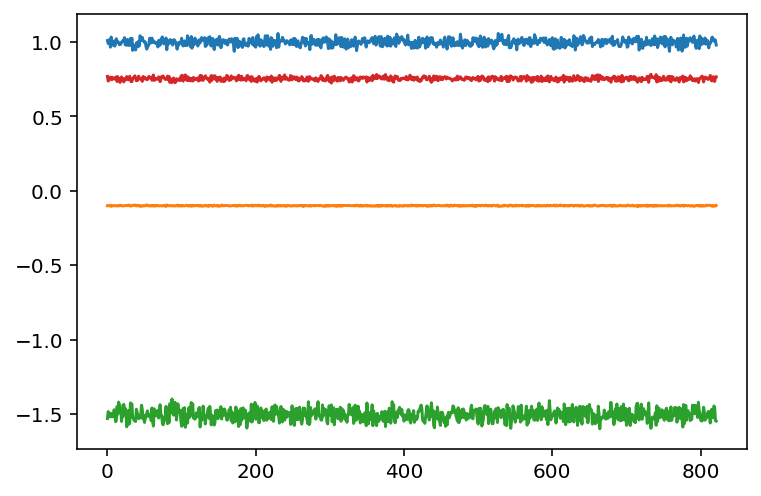

In [128]:
plt.plot(new_new_parameters)

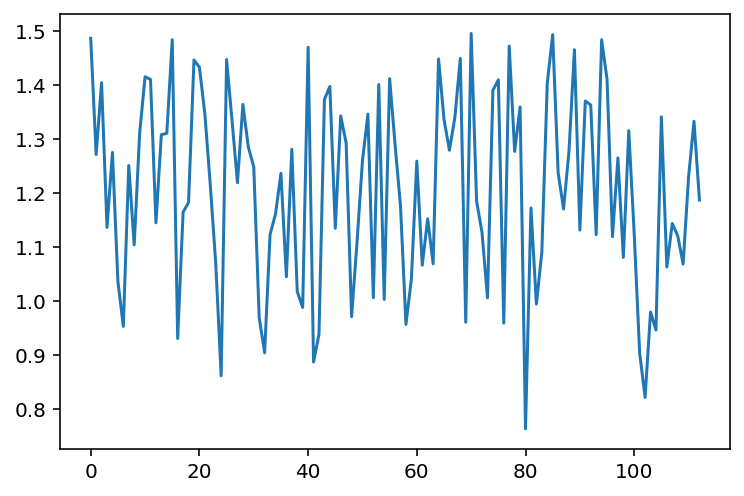

In [59]:
plt.plot(lambdalist)

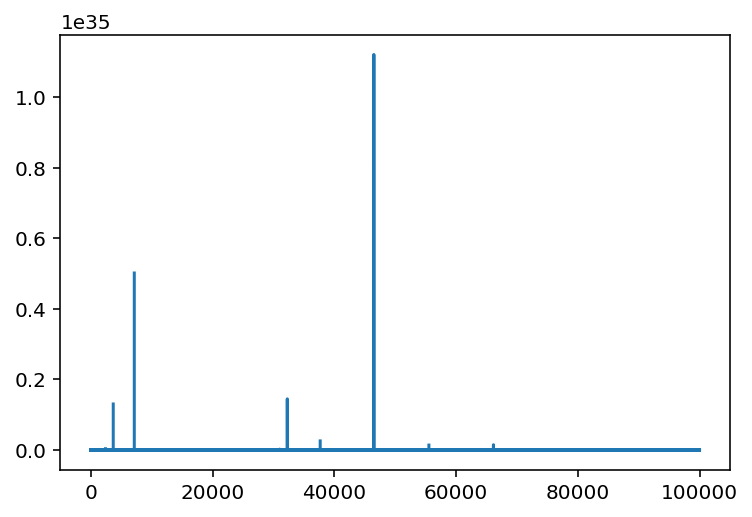

In [60]:
plt.plot(loss)

In [118]:
parameters

array([[ 1.09550368, -0.12294231, -1.36026727,  0.87030879],
       [ 1.39348442, -0.13677173, -0.83589038,  0.61363321],
       [ 1.28143783, -0.11305973, -1.3053157 ,  0.73490739],
       [ 1.08504898, -0.13262167, -1.15016426,  0.773957  ],
       [ 0.76425282, -0.08974644, -1.12317056,  0.68462889],
       [ 1.1536613 , -0.14434117, -1.7710861 ,  0.82280915],
       [ 1.42095992, -0.14191548, -1.70539945,  0.78390916],
       [ 0.80936982, -0.09862969, -0.82353816,  0.59381275],
       [ 0.87382874, -0.0867278 , -1.76577042,  0.65860755],
       [ 0.93886201, -0.11300137, -1.47364441,  0.80746997],
       [ 0.89152328, -0.13390818, -1.03232563,  0.67147076],
       [ 0.7227749 , -0.10754325, -1.22643794,  0.58081792],
       [ 1.00862648, -0.10644503, -1.73993589,  0.92341737],
       [ 0.64328079, -0.07361109, -0.97874632,  0.6505799 ],
       [ 0.83499848, -0.09403443, -0.99696263,  0.67299515],
       [ 0.71604307, -0.103682  , -0.98763337,  0.6046756 ],
       [ 1.31107383, -0.

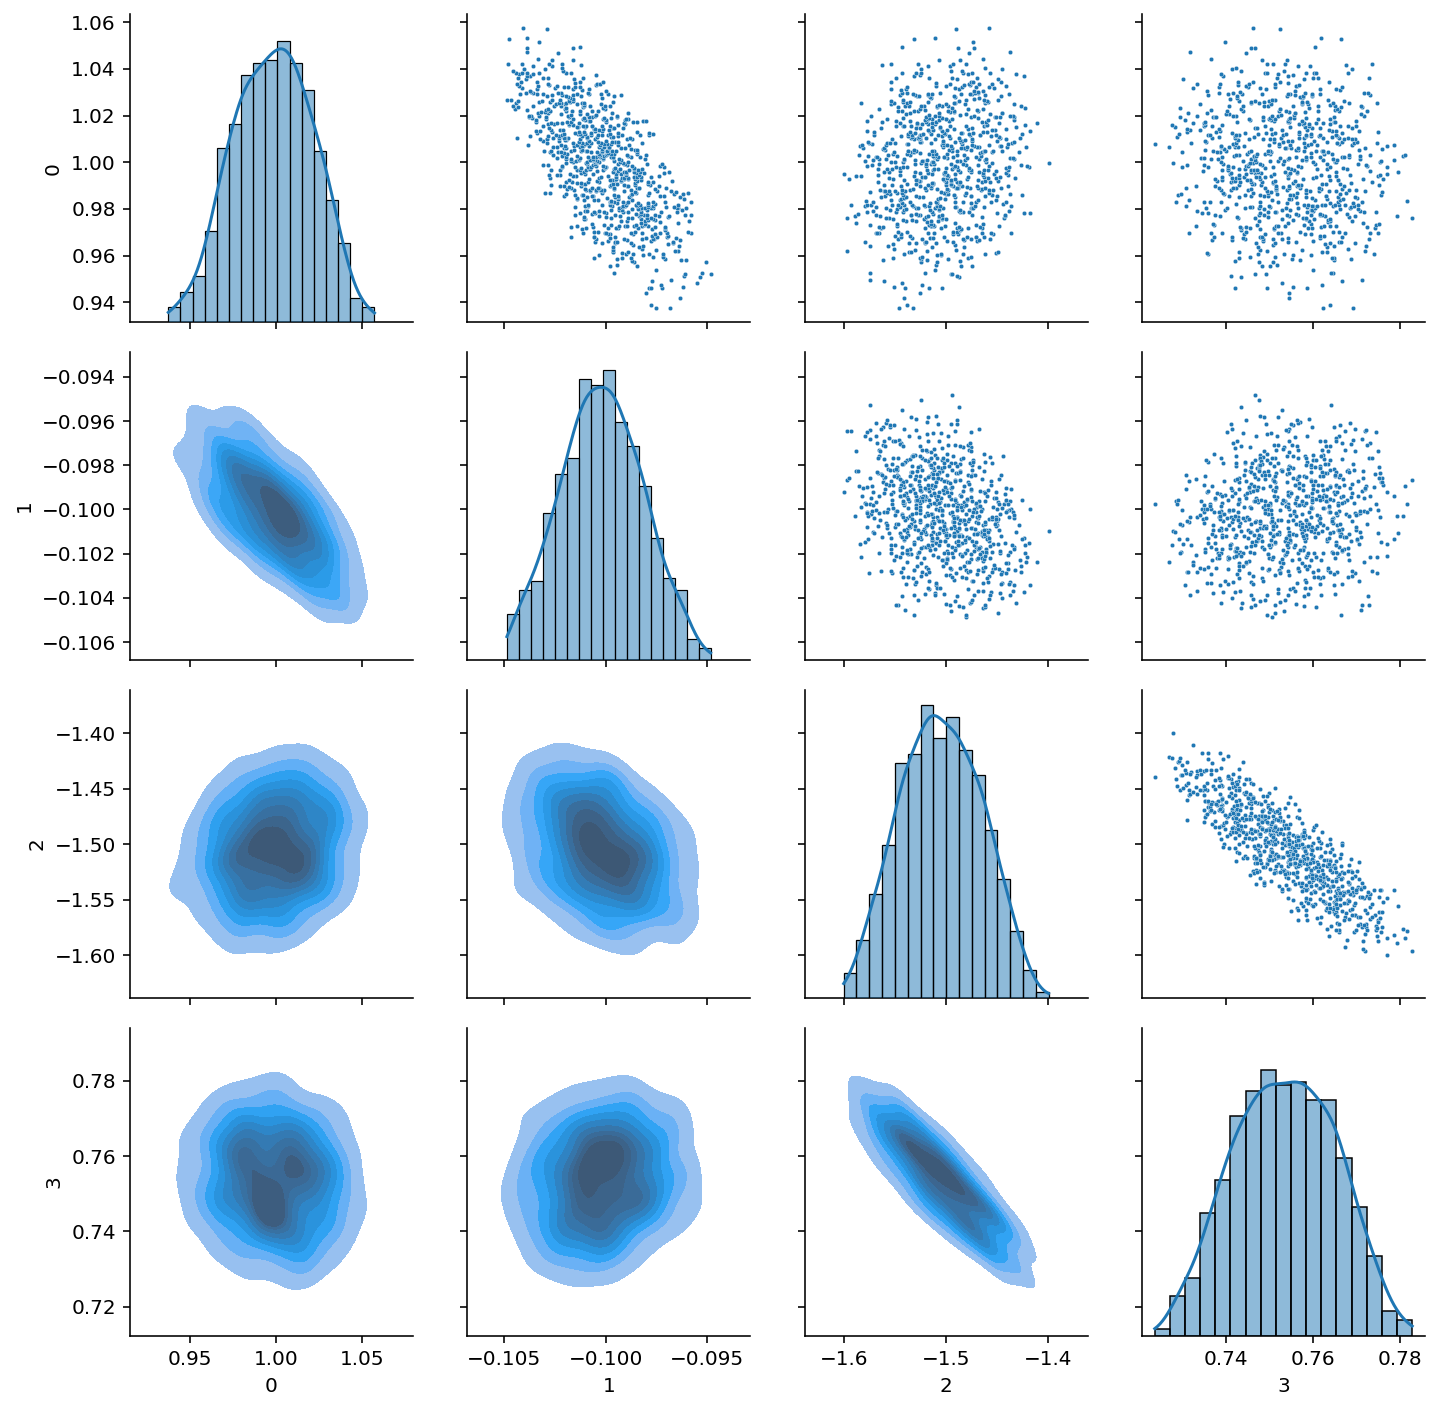

In [129]:
import seaborn as sns
import pandas as pd

g = sns.PairGrid(pd.DataFrame(np.unique(new_new_parameters, axis = 0)))
g.map_upper(sns.scatterplot, s = 5)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

In [137]:
t_grid = np.linspace(0, 25, data_size) # uniformly spaced data? -> even though advantage is learning with not uniformly spaced data
z0 = [5., 5.] # initial conditions
 
for j in tqdm(range(parameters.shape[0])):
    simul_yy =  odeint(VP, z0, t_grid, args=tuple(parameters[j]))
    plot_traj_gray(simul_yy)

true_yy = odeint(SIR, z0, t_grid, args=(beta, gamma))  # potrebbe aver senso tenerli in memoria se è lento
plot_traj(true_yy)

    
plt.show()

  0%|                                                                                          | 0/458 [00:00<?, ?it/s]C:\Users\fedfa\Anaconda3\envs\tf_env\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
  0%|                                                                                          | 0/458 [00:00<?, ?it/s]


NameError: name 'plot_traj_gray' is not defined

In [125]:
import arviz as az

az.ess(new_new_parameters[:,1])

693.7897807481573

In [ ]:
az.plot_posterior(parameters[:,0],hdi_prob = 0.95, ref_val = 1)

In [ ]:
az.plot_posterior(parameters[:,1],hdi_prob = 0.95, ref_val = -0.1)

In [ ]:
az.plot_posterior(parameters[:,2],hdi_prob = 0.95, ref_val = -1.5)

In [ ]:
az.plot_posterior(parameters[:,2],hdi_prob = 0.95, ref_val = 0.75)

In [ ]:
az.plot_mcse(parameters[:,1])